# Classifying the Risk Intensity Level for Maternal Mortality during Pregnancy
#### Raychal Ng, Aniket Chakraborty, Hamrah R, Revanda Ghassan R

## Introduction

This dataset presents six factors that affect maternal mortality: age; systolic BP ( pressure in the arteries when the heart beats in mmHg); diastolic BP (pressure in the arteries during rests between beats in mmHg); blood sugar (blood glucose level in mmol/L), body temperature (in Fahrenheit), and heart rate in beats per minute. Deviation from normal levels in these factors contributes to maternal mortality. The data was obtained from different hospitals and clinics in Bangladesh. It was collected using the loT-based risk monitoring system which contains data from mechanical and digital machines used on patients. The risk level for mortality was classified for 1014 pregnancies based on midwifery assessments [1]. 

#### Predictive Question
We aim to answer the question: Can we reliably predict maternal mortality in the future based on data collected during patient admission, i.e. age, systolic BP, diastolic BP and blood sugar.

## Methods & Results

### Preliminary Exploratory Data Analysis

In [34]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(RColorBrewer)

In [35]:
# Download the chosen dataset
# Make RiskLevel a factor variable since that will be our target variable for prediction
# Import column names

maternal_health_dataset <- read_csv("https://raw.githubusercontent.com/aniketc12/maternal_risk/main/data/maternal_health_risk.csv") 
maternal_health_dataset <- maternal_health_dataset |>
    mutate(RiskLevel =as_factor(RiskLevel))
colnames(maternal_health_dataset) <- c("Age", "SystolicBP", "DiastolicBP", "BloodSugar", "BodyTemp", "HeartRate", "RiskLevel") 

Rows: 1014 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [36]:
set.seed(1) #seed was set to ensure reproducibility of code 

# Select all columns except BodyTemp and HeartRate as these were not a part of our chosen variables (discussed in graphs 1-4 section) 
maternal_health_dataset <- maternal_health_dataset |>
    select(!c("BodyTemp", "HeartRate")) 


# Split the dataset was split into a training and testing set with 75% of the data being allocated to the training set
# set strata = RiskLevel to ensure equal proportions of each risk level was distributed to each set in the split
maternal_split <- initial_split(maternal_health_dataset, prop = 0.75, strata = RiskLevel) 

training_set <- training(maternal_split)
testing_set <- testing(maternal_split)

#### Graphs 1 to 4: Distribution of Chosen Variables in Each Risk Level for Maternal Mortality

Graphs 1 to 4 show the distribution of each chosen variable across each risk level using overlaid density graphs. The risk levels for maternal mortality were visualized using different colors. 

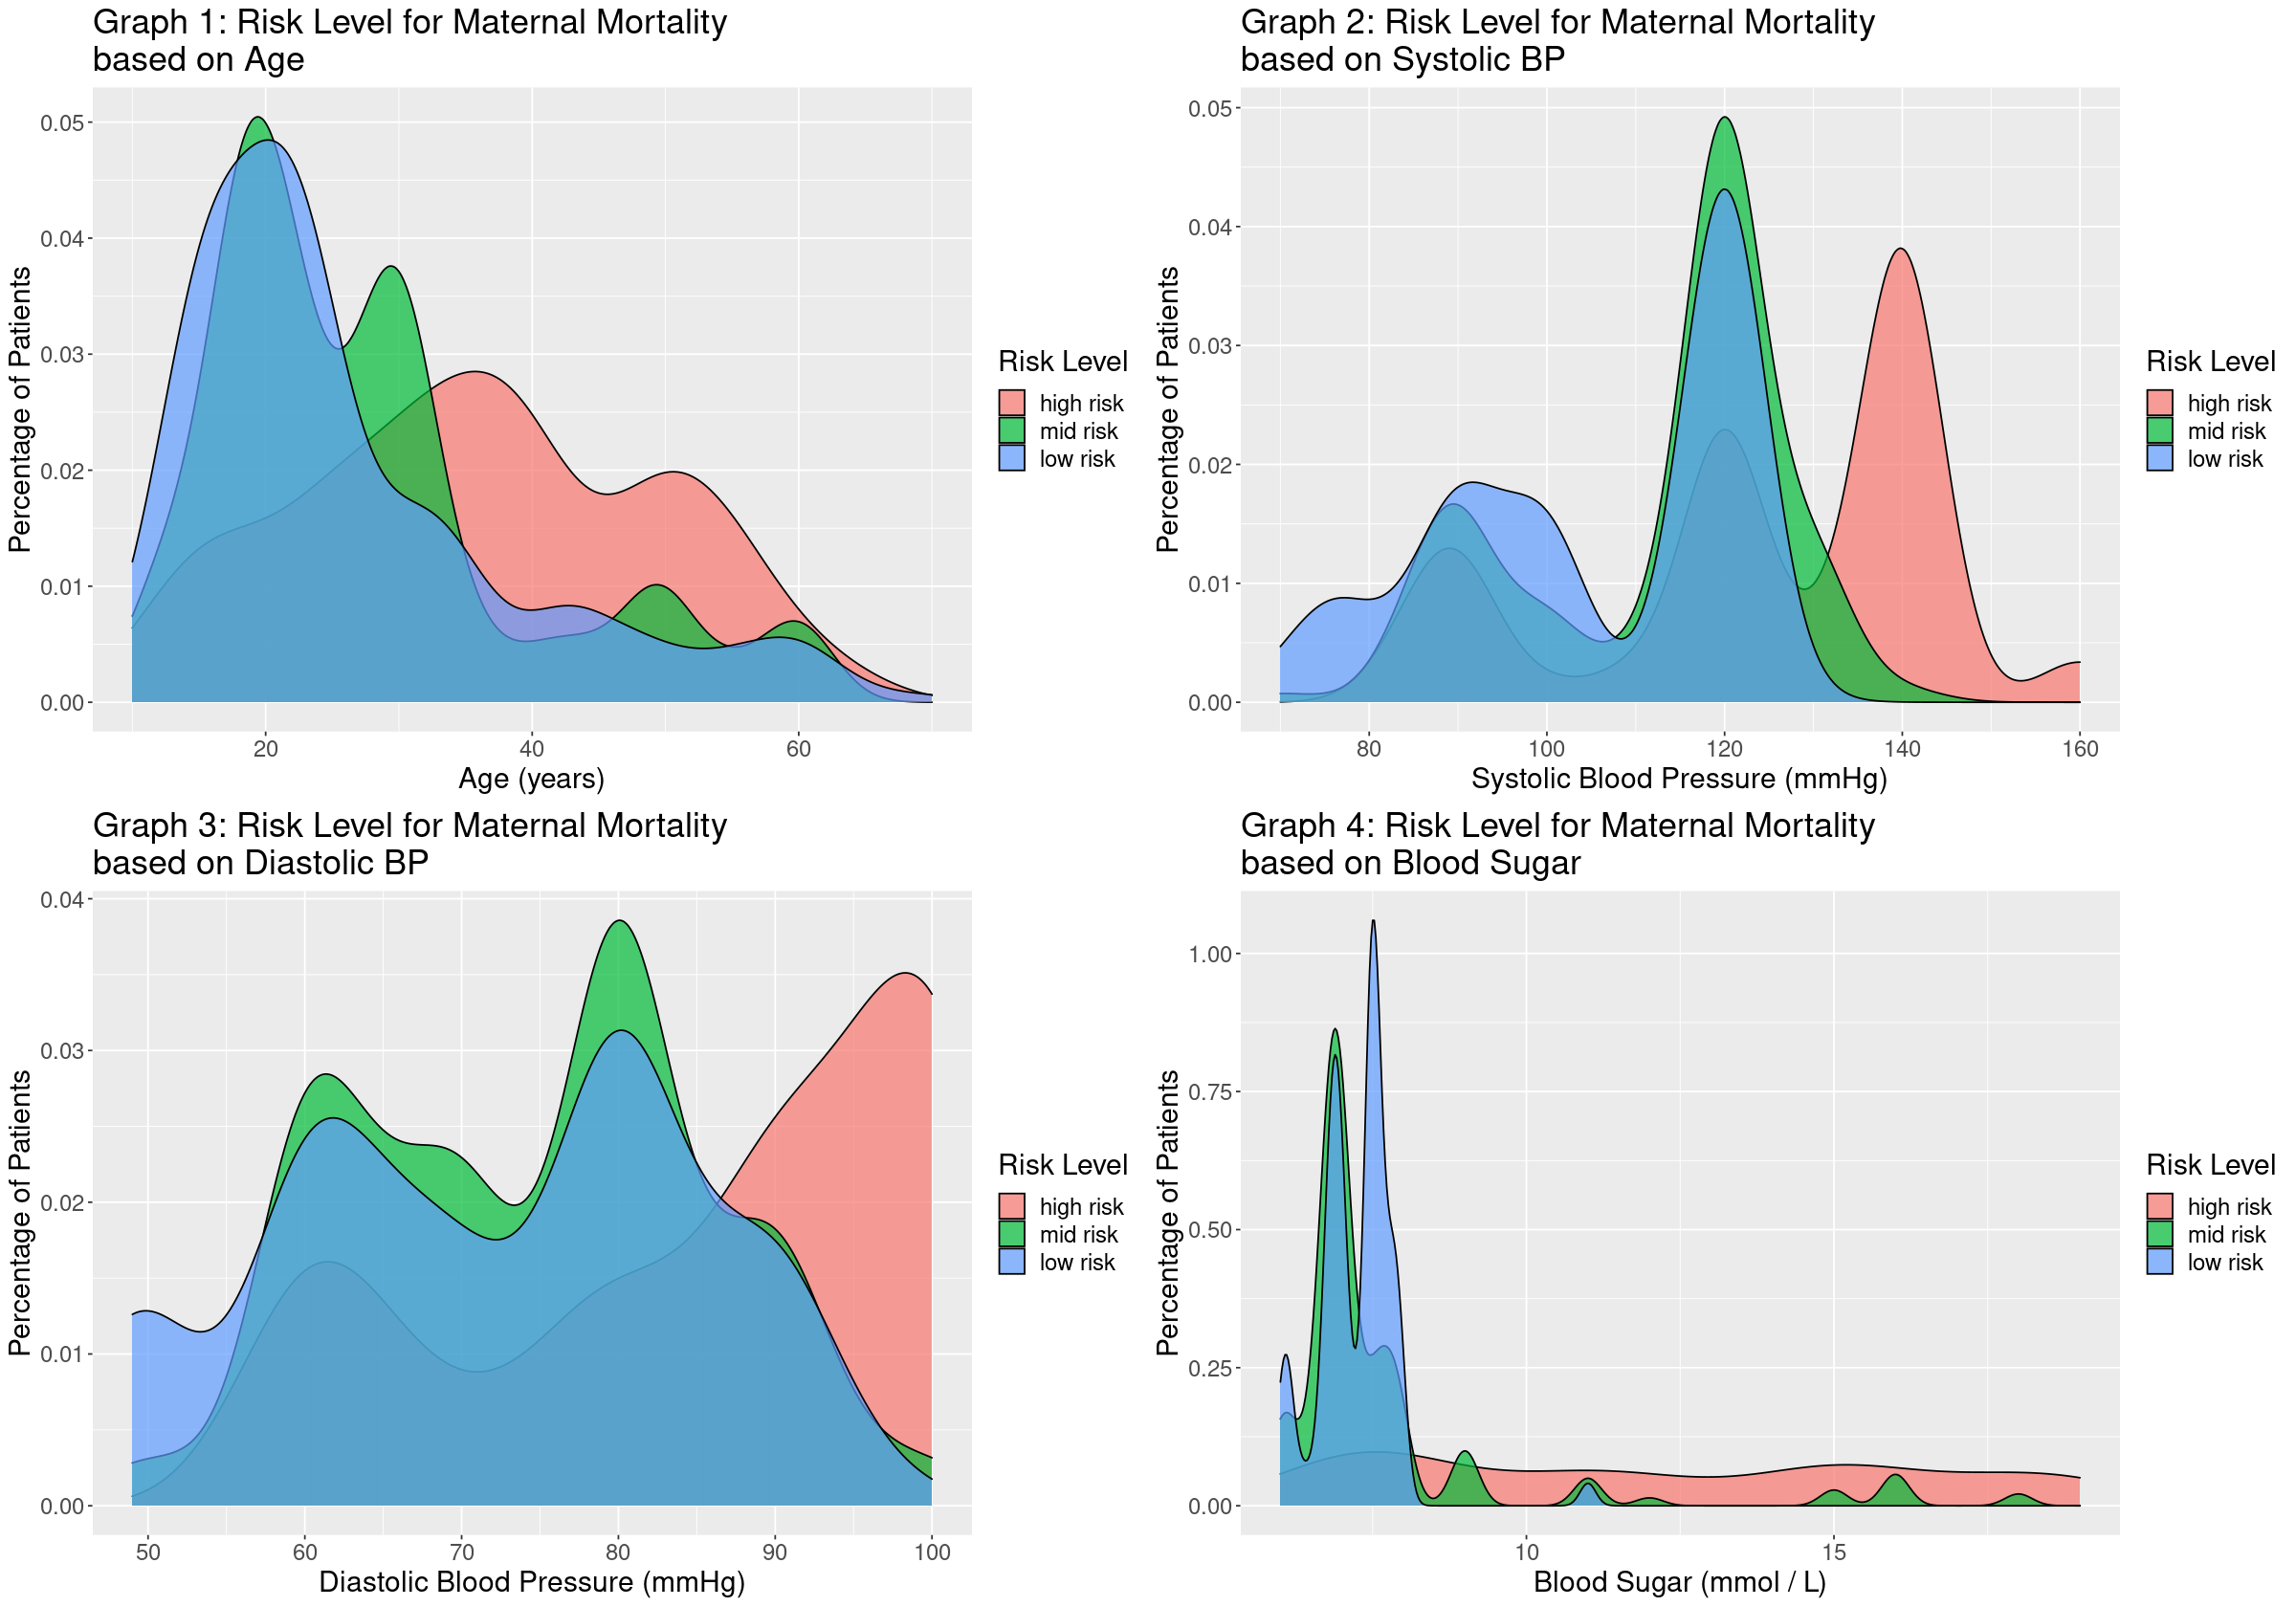

In [37]:
alpha <- 0.7 #alpha set to 0.7 to allow for slight transparency in the three plotted distributions

# Create density graphs to show the distributions of the chosen variables
# Fill the different denisty curves with different colors to signifiy the different risk levels
# Change the order of the risk level to go from high to low to increase readability of graph

# This creates a density graph to visualize the distribution of ages for each risk level
age_density <-  ggplot(training_set, aes(x = Age)) + 
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) + 
labs(x = "Age (years)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 1: Risk Level for Maternal Mortality \nbased on Age")

# This create a density graph to visualize the distribution of Systolic BP for each risk level
systolic_density <-  ggplot(training_set, aes(x = SystolicBP)) + 
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Systolic Blood Pressure (mmHg)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 2: Risk Level for Maternal Mortality \nbased on Systolic BP")

# This create a density graph to visualize the distribution of Diastolic BP for each risk level
diastolic_density <-  ggplot(training_set, aes(x = DiastolicBP)) +
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Diastolic Blood Pressure (mmHg)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 3: Risk Level for Maternal Mortality \nbased on Diastolic BP")

# This create a density graph to visualize the distribution of Blood Sugar for each risk level
bs_density <- ggplot(training_set, aes(x = BloodSugar)) + 
geom_density(aes(fill = factor(RiskLevel, levels = c("high risk", "mid risk", "low risk"))), alpha=alpha) +
labs(x = "Blood Sugar (mmol / L)", y = "Percentage of Patients", fill = "Risk Level") +
theme(text = element_text(size = 18)) +
ggtitle("Graph 4: Risk Level for Maternal Mortality \nbased on Blood Sugar")

# Arrange graphs into a grid containing 2 graphs per row for ease of visualizing the density plots
options(repr.plot.height = 14, repr.plot.width = 20) 
grid.arrange(age_density, systolic_density, diastolic_density, bs_density, nrow = 2) 

Graphs 1 to 4 shows the distribution of the variables in each risk level for maternal mortality. Graph 1 shows a positive correlation between age and risk level. Graphs 2 and 3 show positive correlations between systolic BP and diastolic BP with risk level, respectively. They also suggest high risk pregnancies are associated with significantly higher systolic and diastolic BP while mid and low risk pregnancies have similar distributions. Graph 4 shows that mid and low risk pregnancies are associated with lower blood sugar levels while high risk pregnancies can be associated with up to very high blood sugar levels. The positive correlations observed between each variable and risk level supports our choice of variables that will be used for predicting maternal mortality risk during pregnancy. 

In addition to the correlations observed between the risk level for maternal mortality and each variable, a literature search was conducted to find supporting evidence for our choice of variables (age, systolic BP, diastolic BP, and blood sugar) that will be used in the classification model. Studies suggest that maternal age increases the risk of several complications relating to the process of childbirth/maternal mortality, including gestational diabetes, hypertension, and pre-eclampsia. Thus, maternal age influences the maternal mortality risk during pregnancy. Furthermore, research shows that between 2010-2012 almost 30% of maternal deaths happened between women ages ranging 30-39 years[1]. Similarly, studies conducted by Boyd et al. investigated patterns of blood pressure in pregnant women, and concluded that women with higher levels of diastolic and systolic blood pressure during their first trimester of pregnancy are at a higher risk of developing hypertensive disorders in pregnancy(HDP)[2]. HDP can lead to increased risk of maternal mortality as well as impact the child’s blood pressure after birth. Blood sugar is our fourth variable. Diabetes is a sign of high blood sugar, and this dysregulation of blood sugar poses a severe risk for maternal mortality, affecting one in six pregnancies around the world[3]. Usually during pregnancies, hemoglobin A1c, which measures the average blood glucose concentration) is tested. In a study conducted by Davidson et al., they found that the rise in hemoglobin A1c correlates to a higher risk in maternal mortality[4]. Body temperature and heart rate were the other two variables included in the original dataset but were not chosen to be used in building our classifier. Most studies that evaluate the relationship between body temperature or heart rate with pregnancies showed a correlation with effects on only the fetus, but not maternal mortality itself. Therefore, the “heart-rate” and “temperature” variable was omitted from the classification model. 

#### Table 1: Number of Observations in Each Maternal Mortality Risk Level 

In Table 1, the distribution of the three risk levels for maternal mortality in the training data was tabulated to determine the spread of data across the classes.

In [38]:
# Group the training data into 3 groups based on their risk level 
# Then calculate the number of observations of each risk level
risk_distribution <- training_set |>
group_by(RiskLevel) |> 
summarize(n=n())
risk_distribution

RiskLevel,n
<fct>,<int>
high risk,204
low risk,304
mid risk,252


The training data was grouped by the three risk levels for maternal mortality and then the number of observations in each group was summarized. As the number of observations in each class is relatively equal (204-304), no further balancing of data is needed and we can proceed with building the classifier.  

#### Table 2: Tabulation of the Total Number of ‘NA’ values in the Training Data 

In [39]:
# Find the total number of missing data
na <- tibble(number_of_na_values = sum(is.na(training_set))) 
na

number_of_na_values
<int>
0


In table 2, the total number of NA values across the training set was summed to determine if there was any missing data in the observations.  However, none of the observations contain an NA value so no special wrangling of data is required and all observations can be used to build the classifier. 

#### Tables 3 to 5: Range of Variables in Each Risk Level

Tables 3 to 5 shows the range (max and min) of the four chosen variables (age, systolic BP, diastolic BP, and blood sugar) for high, mid and low risk pregnancies, respectively. There is a wide range of data for each class and the max and min of the four variables do not differ drastically between the classes.

#### Table 3: Max and Minimum Values of the Variables in High Risk Pregnancies

In [41]:
# Filter the training set to show only observations from the high risk class
# Find the maximum and minimum values of each variable to analyse the spread of the high risk class

# Here we find the minimum values for each variable
min_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |> 
    select(!RiskLevel) |> 
    map_df(min) 
# Here we find the maximum values for each variable
max_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |>
    select(!RiskLevel) |>
    map_df(max) 

# Join the maximum and minimum values for readability
high_risk_variable_range <- full_join(min_vals_high, max_vals_high) 

high_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
12,83,60,6.1
65,160,100,19.0


Table 3 shows the range of each variable for pregnancies categorized as high risk: the age ranged from 12-65 years old, the Systolic BP ranged from 83-160 mmHg, the Diastolic BP ranged from 60-100 mmHg, and the blood sugar ranged from 6.1-19.0 mmol/L.

#### Table 4: Max and Minimum Values of the Variables in Mid Risk Pregnancies

In [42]:
# Filter the training set to show only observations from the mid risk class
# Find the maximum and minimum values of each variable to analyse the spread of the high risk class

# Here we find the minimum values for each variable
min_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |> 
    select(!RiskLevel) |>
    map_df(min)

# Here we find the maximum values for each variable
max_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |>
    select(!RiskLevel) |>
    map_df(max)

# Join the maximum and minimum values for readability
mid_risk_variable_range <- full_join(min_vals_mid, max_vals_mid)

mid_risk_variable_range


Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,50,6
60,140,100,18


Table 4 shows the range of each variable for pregnancies categorized as mid risk: the age ranged from 10-60 years old, the Systolic BP ranged from 70-140 mmHg, the Diastolic BP ranged from 50-100 mmHg, and the blood sugar ranged from 6-18 mmol/L.

#### Table 5: Max and Minimum Values of the Variables in High Risk Pregnancies

In [43]:
# Filter the training set to show only observations from the low risk class
# Find the maximum and minimum values of each variable to analyse the spread of the high risk class

# Here we find the minimum values for each variable
min_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |> 
    select(!RiskLevel) |>
    map_df(min) 

# Here we find the maximum values for each variable
max_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |>
    select(!RiskLevel) |>
    map_df(max)

# Join the maximum and minimum values for readability
low_risk_variable_range <- full_join(min_vals_low, max_vals_low)

low_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,49,6
70,129,100,11


Table 5 shows the range of each variable for pregnancies categorized as low risk: the age ranged from 10-70 years old, the Systolic BP ranged from 70-129 mmHg, the Diastolic BP ranged from 49-100 mmHg, and the blood sugar ranged from 6-11 mmol/L.

### Data Analysis: Creating the Classifier, Cross Validation and Evaluating the Classifier

In [44]:
set.seed(1)

# Create a recipe to complete the data pre-processing required for a knn model (using only the training set)
# The target variable is RiskLevel and predictors are all the remaining variables selected in the training set
# The recipe will scale all variable to ensure that the standard deviation = 1 
# so that the scale of variables don't unfairly affect the classification
# Center all variable for best practice
maternal_recipe <- recipe(RiskLevel ~ ., data=training_set) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

# Create a cross-validation set with v=10
maternal_vfold <- vfold_cv(training_set, v = 10, strata = RiskLevel)  


# Define knn model specifications
# Here we will set neighbor=tune() since we want to iterate over multiple values of k in order to pick
# the k that gives us the best accuracy
# Set mode to classification 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

# Create tibble with target k values to iterate over during cross validation (to pick best k)
# We choose 1 to 20 for k since out dataset has under about a total of 1000 total observations and
# going over 20 would make the model underfit the dataset
ks <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# Create a workflow to put together the recipe and model, do the cross validation and then collect the required metrics
knn_results <- workflow() |>  
    add_recipe(maternal_recipe) |> 
    add_model(knn_spec) |>
    tune_grid(resamples = maternal_vfold, grid = ks) |> 
    collect_metrics() 

# Collect the accuracies from the set of all metrics
accuracies <- knn_results |>
    filter(.metric == "accuracy")

#### Graph 5: Cross-validation Accuracy Estimate vs Number of Neighbours 


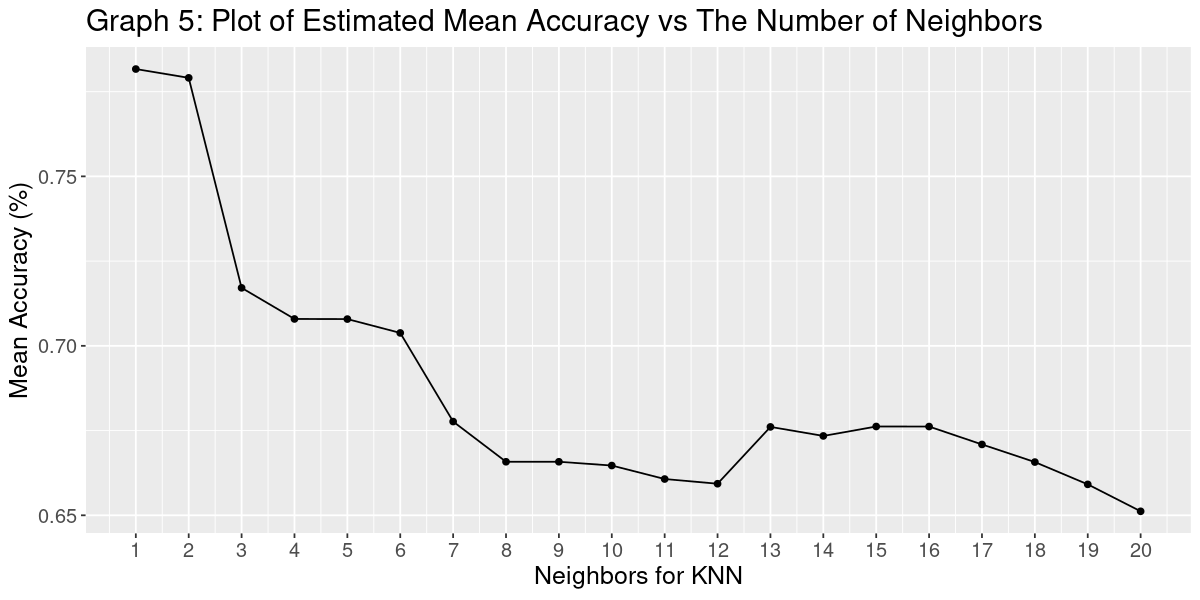

In [45]:
options(repr.plot.height = 5, repr.plot.width = 10)

# Create a plot of accuracy vs k to select the best k
accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors for KNN", y = "Mean Accuracy (%)") + 
  theme(text = element_text(size = 15)) +
    ggtitle("Graph 5: Plot of Estimated Mean Accuracy vs The Number of Neighbors") +
    scale_x_continuous(breaks = seq(0,20, by = 1))

accuracies_plot

The graph above was made to determine what value of k or the number of neighbors for our classification model would yield the highest accuracy when predicting our cross-validation set. From the graph, which shows the estimated mean accuracy vs the number of neighbors, we can see that 1 neighbor has the highest accuracy for our model. However, choosing k to be 1 is not appropriate as this would lead to overfitting where the classifications are too sensitive to the data points and do not consider the larger pattern. Accounting for this, we choose k to be 2 neighbors as it produced the second highest accuracy estimate. We were skeptical about this value of k being too small and possibly overfitting of the data still, however, all succeeding values for k led to a very significant decrease in the accuracy of the classifier. 

#### Table 6: Accuracy of Classifier in Predicting Testing Set 

In [46]:
set.seed(1)
# Based on the graph we chose k=2
best_k <- 2 

# Create new knn model specifications with the newly chosen best k
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a workflow to put together the recipe with the new model and fit the model
best_knn_fit <- workflow() |>
    add_recipe(maternal_recipe) |>
    add_model(best_knn_spec) |>
    fit(data=training_set)

# Use the fitted model to predict on the testing data to see how it performs with "real" data
# Collect the accuracies by comparing the true labels with the predicted labels.
testing_set_predictions <- predict(best_knn_fit, testing_set) |> 
    bind_cols(testing_set)

testing_set_accuracies <- testing_set_predictions |> 
    metrics(truth = RiskLevel, estimate = .pred_class) |>
    filter(.metric == "accuracy")
testing_set_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7913386


The abiity of our classifier to accurately predict the risk level of the observations in the testing set was evaluated. Our classifier had an estimated accuracy of 79.13% meaning that it correctly predicted the risk level of the maternal patients 79.13% of the time and made an incorrect prediction 20.87% of the time.

#### Table 7: Confusion Matrix for Classifier’s Accuracy against Testing Set

In [47]:
# Visualize our model's predictions against the true risk level values in a confusion matrix to see its 
# accuracy and the kind of mistakes the classifier makes
testing_set_confusion <- testing_set_predictions |>
    conf_mat(truth = RiskLevel, estimate = .pred_class) 


testing_set_confusion

           Truth
Prediction  high risk low risk mid risk
  high risk        56        1        7
  low risk          4       86       18
  mid risk          8       15       59

A confusion matrix was generated to determine the number of correct predictions the classifier made compared to the type and number of incorrect predictions it made. The classifier made generally accurate predictions. The dominant mistakes made were that the classifier predicted mid risk for a high risk pregnancy, predicted mid risk for a low risk pregnancy and predicted low risk for a mid risk pregnancy. Overall, the classifier made the fewest mistakes when predicting high risk pregnancies. 

#### Graph 6: Proportion of Correct vs Incorrect Predictions for Each Risk Level 

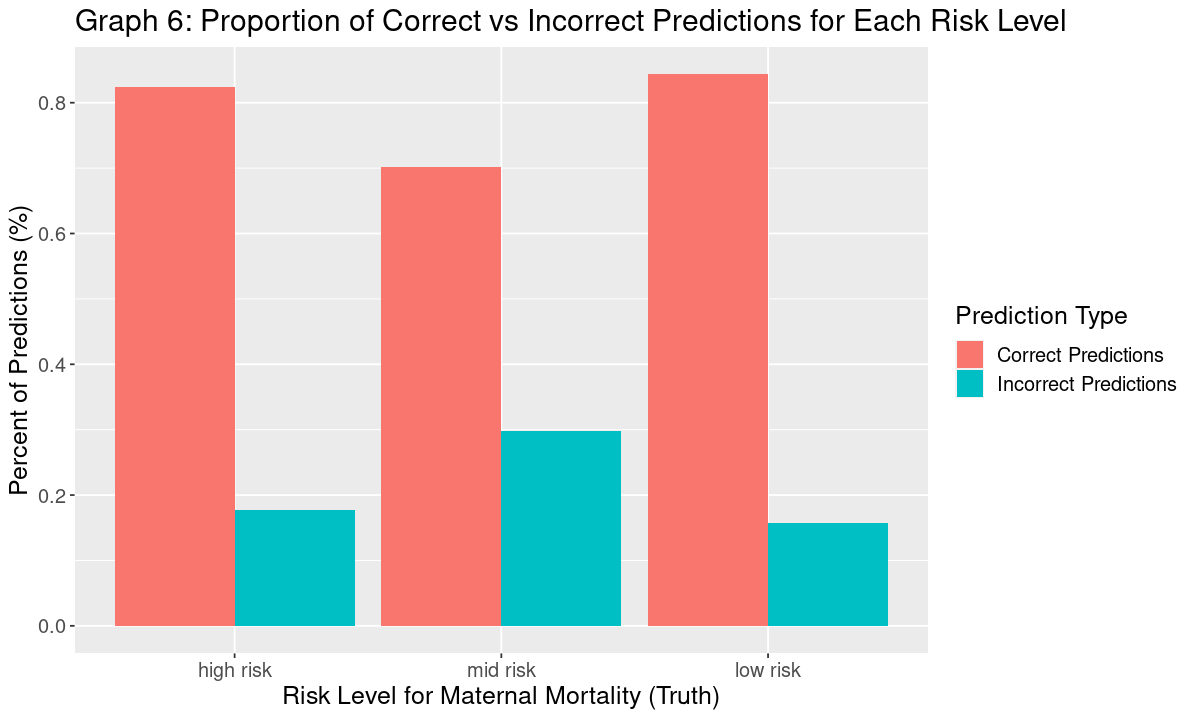

In [48]:
# 3 bar graphs for truth = each risklevel, show the proportion of right vs wrong classifications
options(repr.plot.width=10, repr.plot.height=6)
conf_mat_table <- data.frame(testing_set_confusion$table)

# Assign levels to the Truth and Predictions so that the graph is more readable
conf_mat_table <- mutate(conf_mat_table, Prediction=factor(Prediction, levels = c("high risk", "mid risk", "low risk"))) |>
    mutate(Truth=factor(Truth, levels = c("high risk", "mid risk", "low risk")))

# Find the number of predictions that were correct and incorrect for each truth label
conf_mat_table_p <- conf_mat_table |>
    mutate(Prediction_type=Prediction==Truth) |>
    mutate(Prediction_type = replace(Prediction_type, Prediction_type==TRUE, "Correct Predictions")) |>
    mutate(Prediction_type = replace(Prediction_type, Prediction_type==FALSE, "Incorrect Predictions")) |>
    group_by(Truth, Prediction_type) |>
    summarize(n=sum(Freq), .groups="keep") |>
    group_by(Truth) |>
    mutate(Percent_of_predictions = n/sum(n)) 

# Create a plot using the table created above
ggplot(conf_mat_table_p, aes(x=Truth, y=Percent_of_predictions, fill=Prediction_type)) +
    geom_bar(stat='identity', position='dodge') +
    labs(x = "Risk Level for Maternal Mortality (Truth)", y = "Percent of Predictions (%)", fill = "Prediction Type") +
    ggtitle("Graph 6: Proportion of Correct vs Incorrect Predictions for Each Risk Level") +
    theme(text = element_text(size = 15))

Graph 6 shows how often the model predicted correctly for each class. In particular, the x axis shows the true labels of the classes and the heights of the bars show the percent of predictions that were correct and incorrect for each class. When the true label for data was "high risk", the model had a testing accuracy of about 82%. Additionally, when the true label for data was "mid risk" the model had a testing accuracy of about 70%  and when the true label was "low risk" the model had a testing accuracy of about 84%. 

### Discussion

We found that the classifier was able to accurately predict the testing set's risk level for maternal mortality 79.13% of the time. The classifier performed the most accurately when predicting low risk pregnancies (about 84%) and the least accurately for mid risk pregnancies (about 70%). The classifier’s main weakness is predicting the risk levels as lower than the actual risk level is. This is less than ideal as the consequences of underestimating maternal mortality risk is fatal. However, for predicting high risk pregnancies, which is arguably the most important as rapid maternal care is essential, the classifier predicted the risk level accurately 56 times (or about 82%) and only incorrectly predicted it 8 times (once as low risk and 7 times as mid risk). The lower than desired prediction accuracy of the classification model is what we expected because classifying the risk level for maternal mortality is very complex and other factors that were not included in the data set must be considered. For example, genetic predisposition based on past family history for maternal complications is a major factor that influences the risk level for maternal mortality and was not considered in our classification [6]. We believe that perfecting our model by including additional relevant variables and improving its accuracy can help hospitals provide appropriate care for patients with a high risk for maternal mortality. The use of other classification algorithms beyond the KNN algorithm may also return a more accurate model and is an area of research that can be explored. In an effort to reduce mortality levels, identifying and prioritizing high risk patients based on diagnostics has been a focus of the medical industry since the 1900s [7]. Hospitals will be able to save intake time, prioritize at risk patients appropriately based on their collected vitals and provide any preemptive care. Additionally, this model is ideal as it is low cost and efficient, requiring only common patient data that is easily acquired with hospital devices (Age , Systolic & Diastolic Blood Pressure, and Blood Sugar). A highly accurate model for predicting maternal mortality risk level can potentially transform patient care. Future questions that our model can lead to include questions in the realm of repurposing our model to predict fetal mortality risk, as well as risk for other maternal complications such as anemia, miscarriage and preterm labour. Additionally, questions surrounding when these variables should be measured (early, middle or late pregnancy or possibly constantly) and how the stage of pregnancy when these measurements are taken affects the mortality risk may arise. 


### References

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2] Bouzaglou, A., Aubenas, I., Abbou, H., Rouanet, S., Carbonnel, M., Pirtea, P., & Ayoubi, J. M. B. (2020, April 27). Pregnancy at 40 years old and above: Obstetrical, fetal, and neonatal outcomes. is age an independent risk factor for those complications? Frontiers. Retrieved December 3, 2022, from https://www.frontiersin.org/articles/10.3389/fmed.2020.00208/full#:~:text=The%20age%20of%20women%20is,age%20group) 

[3] Boyd, H. A., Al, E., & Birukov, A. (2020, August 12). Maternal blood pressure during pregnancy. Hypertension. Retrieved December 3, 2022, from https://www.ahajournals.org/doi/10.1161/HYPERTENSIONAHA.120.15458 

[4] Silva, C. M., Arnegard, M. E., & Maric-Bilkan, C. (2021, February). Dysglycemia in pregnancy and maternal/fetal outcomes. Journal of women's health (2002). Retrieved December 3, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8020552/#:~:text=Pregnant%20women%20with%20any%20form,than%20the%20general%20obstetric%20population  

[5] ScienceDaily. (2020, May 22). Glucose levels linked to maternal mortality even in non-diabetic women. ScienceDaily. Retrieved December 3, 2022, from https://www.sciencedaily.com/releases/2020/05/200522105751.htm 

[6] Slocumb, J. C., & Kunitz, S. J. (1977). Factors affecting maternal mortality and morbidity among American Indians. Public health reports (Washington, D.C. : 1974), 92(4), 349–356.

[7] Davenport, T., & Kalakota, R. (2019, June). The potential for artificial intelligence in Healthcare. Future healthcare journal. Retrieved December 5, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616181/ 